# Bidding engine development

# Table of contents

- [Imports](#imports)
    - [Libraries](#libraries)
    - [Raw data](#raw-data)
- [Processing](#processing)
    - [Missing values](#missing-values)
        - [Forward fill](#filling-with-linear-ffill)
        - [Imputing with most frequent](#filling-with-most-frequent)
        - [Imputing with nearest neighbors](#filling-with-neighbours)
    - [Converting object features to numerical](#converting-object-features-to-numerical)
    - [Scaling metrics features](#scaling-metrics-features)
    - [Downcasting numerical features](#downcasting-numerical-features)
    - [Profiling interim data](#timeseries-of-the-random-feature-for-the-random-keyword)
- [Feature engineering](#feature-engineering)
    - [Add ROI](#add-roi)
    - [Convert CPC to GBP](#convert-cpc-to-gbp)
- [Quick look into keywords](#preliminary-keyword-analysis)
    - [Most sessions](#most-sessions)
    - [Least sessions](#least-sessions)
    - [Most impressions](#most-impressions)
    - [Least impressions](#least-impressions)
- [Tokenize](#tokenize)

# Imports
[top](#table-of-contents)

## Libraries


In [146]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from sklearn.impute import KNNImputer, SimpleImputer
from transformers import AutoTokenizer
import torch

SEED = 1
np.random.seed(seed=SEED)
torch.manual_seed(seed=SEED)
load_dotenv()

True

## Raw data

In [43]:
raw_df = pd.read_feather(
    os.path.join(os.environ['RAW_DATA_PATH'], 'bidding_data.feather'))


In [44]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587593 entries, 0 to 587592
Data columns (total 19 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   AdGroupId                         587593 non-null  int64         
 1   CampaignId                        587593 non-null  int64         
 2   CriterionId                       587593 non-null  int64         
 3   Date                              587593 non-null  datetime64[ns]
 4   CampaignName                      587593 non-null  object        
 5   AdGroupName                       587593 non-null  object        
 6   Criteria                          587593 non-null  object        
 7   CpcBid                            587593 non-null  float64       
 8   AbsoluteTopImpressionPercentage   587593 non-null  object        
 9   TopImpressionPercentage           587593 non-null  object        
 10  SearchImpressionShare           

In [45]:
raw_df.isna().sum()

AdGroupId                            0
CampaignId                           0
CriterionId                          0
Date                                 0
CampaignName                         0
AdGroupName                          0
Criteria                             0
CpcBid                               0
AbsoluteTopImpressionPercentage      0
TopImpressionPercentage              0
SearchImpressionShare                0
SearchTopImpressionShare             0
SearchRankLostTopImpressionShare     0
Impressions                          0
Clicks                               0
Cost                                39
Sessions                             0
Cost_gbp                             0
Margin                               0
dtype: int64

In [46]:
sum(raw_df.duplicated())

0

In [47]:
raw_df.head()

,AdGroupId,CampaignId,CriterionId,Date,CampaignName,AdGroupName,Criteria,CpcBid,AbsoluteTopImpressionPercentage,TopImpressionPercentage,SearchImpressionShare,SearchTopImpressionShare,SearchRankLostTopImpressionShare,Impressions,Clicks,Cost,Sessions,Cost_gbp,Margin
0,146372240840,19026016545,1224358859735,2022-10-07,GEN_Date,GEN_2023_Easter_Exact,easter 2023 holidays,1824000.0,0.0,0.0,< 10%,0.12,1.08,0,0.0,0.0,0.0,0.00000,0.0
1,143665838613,19032609979,436468614376,2022-11-17,GEN_Type_Type,GEN_5 Star_Beach_BMM,+beach +holidays +5 +star,2160000.0,0.348,1.2,53.85%,0.648,0.552,9,0.0,0.0,0.0,0.00000,0.0
2,142284478245,19032615052,151556316,2022-09-21,GEN_Type_Date,GEN_Cheap_Christmas_Exact,cheap christmas vacations,708000.0,0.8999999999999999,1.2,100.00%,1.2,0.0,9,1.2,1008000.0,1.2,1.02816,0.0
3,142284480445,19032615052,11690633763,2022-10-20,GEN_Type_Date,GEN_Deals_January_Exact,jan holiday deals,2544000.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00000,0.0
4,146372241280,19026016545,1416199961232,2022-11-17,GEN_Date,GEN_2023_August_BMM,+august +vacations +2023,1260000.0,0.0,0.0,100.00%,0.12,1.08,3,0.0,0.0,0.0,0.00000,0.0


Observations

1. 39 (out of 587,593) NaNs in `Cost` column. Nans rows can be dropped due to insignificant amount. Alternatively, can interpolated (forward fill)

2. The following columns could be converted to numerical (floats) judging by the `bidding_df.head()` and columns names
```
8   AbsoluteTopImpressionPercentage   587593 non-null  object        
9   TopImpressionPercentage           587593 non-null  object        
10  SearchImpressionShare             587593 non-null  object        
11  SearchTopImpressionShare          587593 non-null  object        
12  SearchRankLostTopImpressionShare  587593 non-null  object        
```

# Processing
[top](#table-of-contents)

In [48]:
interim_df = raw_df.copy(deep=True)
interim_df_sorted = interim_df.sort_values(
    by=['CriterionId', 'Date']).reset_index(drop=True)


In [49]:
def plot_keyword(df, criterion, features):
    """
    The plot_keyword function takes a dataframe, criterion ID, and list of features to plot.
    It then plots the specified features for the given criterion ID.
    
    Parameters
    ----------
        df
            Pass the dataframe to the function
        criterion
            Select the keyword to plot
        features
            Specify which columns to plot
    """
    for feature in features:
        plt.plot(df.loc[df['CriterionId'] == criterion, 'Date'],
                 df.loc[df['CriterionId'] == criterion, feature],
                 label=feature)
    plt.title('Keyword ID {}\nUnique keywords {}'.format(
        criterion, raw_df.loc[raw_df['CriterionId'] == criterion,
                              'Criteria'].unique()))
    plt.xticks(rotation=45)
    if len(features) == 1:
        plt.ylabel(feature)
    else:
        plt.legend()
    plt.show()

In [50]:
def plot_filled(df, criterion, features):
    """
    The plot_filled function takes a dataframe, criterion ID, and list of features as input.
    It then plots the filled values for each feature in the list against the date.
    If there is only one feature in the list, it labels that axis with that feature name.
    
    Parameters
    ----------
        df
            Pass the dataframe to the function
        criterion
            Filter the dataframe to only show the rows that have a criterionid equal to criterion
        features
            Specify which columns to plot
    """
    from matplotlib.markers import MarkerStyle

    markers = list(MarkerStyle.markers.keys())[1:len(features) + 1]
    plt.figure()
    for feature, marker in zip(features, markers):
        if 'filled' in feature:
            plt.plot(df.loc[(df['CriterionId'] == criterion)
                            & (df['Cost'].isna()), 'Date'],
                     df.loc[(df['CriterionId'] == criterion) &
                            (df['Cost'].isna()), feature],
                     marker,
                     label=feature)
        else:
            plt.plot(df.loc[df['CriterionId'] == criterion, 'Date'],
                     df.loc[df['CriterionId'] == criterion, feature],
                     label=feature)
    plt.title('Keyword ID {}\nUnique keywords {}'.format(
        criterion,
        df.sort_values(
            by=['CriterionId', 'Date']).loc[df['CriterionId'] == criterion,
                                            'Criteria'].unique()))
    plt.xticks(rotation=45)
    if len(features) == 1:
        plt.ylabel(feature)
    else:
        plt.legend()
    plt.show()

## Missing values

In [51]:
missing_criterionids = raw_df.loc[raw_df['Cost'].isnull(),
                                  'CriterionId'].unique()

In [52]:
print(f'unique keywords with missing values: {len(missing_criterionids)}')

unique keywords with missing values: 39


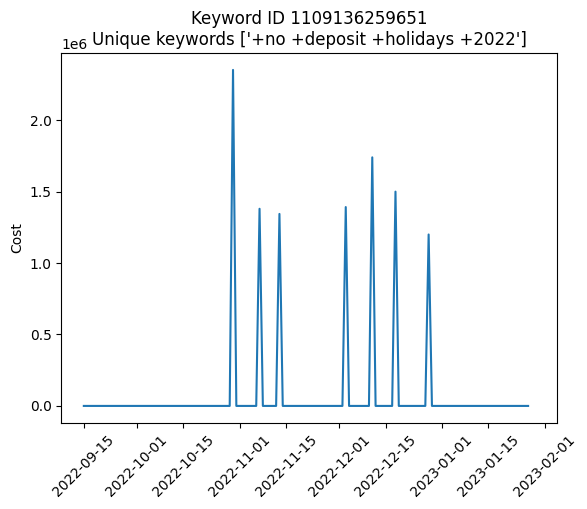

In [53]:
criterion = np.random.choice(missing_criterionids)
features = ['Cost']
plot_keyword(df=interim_df_sorted, criterion=criterion, features=features)

### Filling with forward fill

In [54]:
interim_df_sorted['Cost_forward_filled'] = interim_df_sorted[
    'Cost'].interpolate(method='ffill')


### Filling with most frequent

In [55]:
frequency_imp = SimpleImputer(strategy='most_frequent')
interim_df_sorted['Cost_frequency_filled'] = interim_df_sorted['Cost']
for criterion in missing_criterionids:
    interim_df_sorted.loc[
        interim_df_sorted['CriterionId'] == criterion,
        'Cost_frequency_filled'] = frequency_imp.fit_transform(
            interim_df_sorted.loc[
                interim_df_sorted['CriterionId'] == criterion,
                'Cost_frequency_filled'].values.reshape(-1, 1)).reshape(-1)


### Filling with neighbours

In [56]:
knn_imp = KNNImputer(n_neighbors=5, weights='distance')
interim_df_sorted['Cost_knn_filled'] = interim_df_sorted['Cost']
for criterion in missing_criterionids:
    interim_df_sorted.loc[
        interim_df_sorted['CriterionId'] == criterion,
        'Cost_knn_filled'] = knn_imp.fit_transform(interim_df_sorted.loc[
            interim_df_sorted['CriterionId'] == criterion,
            'Cost_knn_filled'].values.reshape(-1, 1)).reshape(-1)


Comparison of the filling methods on the random keyword

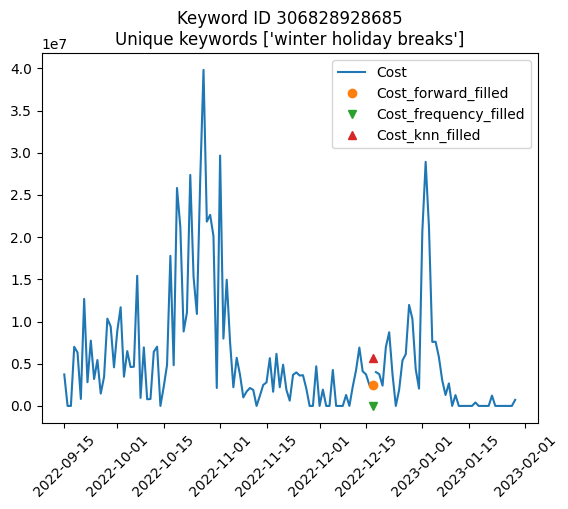

keyword 306828928685. mode: 0.0


In [57]:
criterion = np.random.choice(missing_criterionids)
plot_filled(df=interim_df_sorted,
            criterion=criterion,
            features=[
                'Cost', 'Cost_forward_filled', 'Cost_frequency_filled',
                'Cost_knn_filled'
            ])
print('keyword {}. mode: {}'.format(
    criterion,
    interim_df_sorted.loc[interim_df_sorted["CriterionId"] == criterion,
                          "Cost"].mode()[0]))


Conclusion on filling NaNs

Due to sparsity of data, filling with the most frequent per keyword value was chosen

In [58]:
interim_df_sorted_no_nans = interim_df_sorted.copy(deep=True)
interim_df_sorted_no_nans['Cost'] = interim_df_sorted_no_nans[
    'Cost_frequency_filled']
interim_df_sorted_no_nans.drop(columns=[
    'Cost_forward_filled', 'Cost_frequency_filled', 'Cost_knn_filled'
],
                               inplace=True)
del knn_imp

## Converting object features to numerical

In [59]:
object_columns = [
    'AbsoluteTopImpressionPercentage', 'TopImpressionPercentage',
    'SearchImpressionShare', 'SearchTopImpressionShare',
    'SearchRankLostTopImpressionShare'
]


In [60]:
for col in object_columns:
    interim_df_sorted_no_nans[col] = interim_df_sorted_no_nans[col].str.lstrip(
        '<').str.rstrip('%').astype(float)


## Scaling metrics features

See the ranges of metrics in [Google Ad API](https://developers.google.com/google-ads/api/fields/v11/metrics)

In [61]:
for col in object_columns:
    interim_df_sorted_no_nans[col] = (interim_df_sorted_no_nans[col] -
                                      interim_df_sorted_no_nans[col].min()
                                      ) / interim_df_sorted_no_nans[col].max()
    if 'Percentage' in col:
        interim_df_sorted_no_nans[col] *= 100

## Downcasting numerical features

In [62]:
fcols = interim_df_sorted_no_nans.select_dtypes('float').columns
icols = interim_df_sorted_no_nans.select_dtypes('integer').columns

interim_df_sorted_no_nans[fcols] = interim_df_sorted_no_nans[fcols].apply(
    pd.to_numeric, downcast='float')
interim_df_sorted_no_nans[icols] = interim_df_sorted_no_nans[icols].apply(
    pd.to_numeric, downcast='integer')


## Profiling interim data

In [63]:
if 'interim_data.html' not in os.listdir(os.environ['DATA_PROFILES_PATH']):
    from ydata_profiling import ProfileReport

    os.makedirs(os.environ['DATA_PROFILES_PATH'], exist_ok=True)
    interim_data_profile = ProfileReport(interim_df_sorted_no_nans,
                                         title='Interim Data Profile')
    interim_data_profile.to_file(
        os.path.join(os.environ['DATA_PROFILES_PATH'], 'interim_data.html'))


# Feature engineering
[top](#table-of-contents)

## Add ROI

In [64]:
interim_df_sorted_no_nans['ROI_gbp'] = interim_df_sorted_no_nans[
    'Margin'].divide(interim_df_sorted_no_nans['Cost_gbp'],
                     fill_value=0).replace({
                         np.inf: 0,
                         np.nan: 0
                     })
interim_df_sorted_no_nans['ROI'] = interim_df_sorted_no_nans['Margin'].divide(
    interim_df_sorted_no_nans['Cost'], fill_value=0).replace({
        np.inf: 0,
        np.nan: 0
    })


## Convert CPC to GBP

In [65]:
micros_to_gbp = interim_df_sorted_no_nans['Cost'].div(
    interim_df_sorted_no_nans['Cost_gbp']).replace({
        np.nan: 0,
        np.inf: 0
    }).unique()[1:].mean()


In [66]:
interim_df_sorted_no_nans[
    'CpcBid_gbp'] = interim_df_sorted_no_nans['CpcBid'] / micros_to_gbp


In [67]:
interim_df_sorted_no_nans['Criteria'] = interim_df_sorted_no_nans[
    'Criteria'].str.replace('+', '', regex=False)


# Quick look into keywords
[top](#table-of-contents)

In [68]:
len(interim_df_sorted_no_nans.loc[(interim_df_sorted_no_nans['ROI_gbp'] > 2) &
                                  (interim_df_sorted_no_nans['Margin'] > 0) &
                                  (interim_df_sorted_no_nans['Sessions'] > 0),
                                  'CriterionId'].unique())


2337

## Most sessions

In [69]:
most_sessions = interim_df_sorted_no_nans.sort_values(
    by=['Sessions'],
    ascending=False).loc[interim_df_sorted_no_nans['ROI_gbp'] > 2,
                         'CriterionId'][:75].unique()
most_sessions

array([1161551891012, 1210258704454,      28171120, 1058788934121,
        299280651749, 1211159817982,   29536831107,     123742112,
         31603113664,  301424692038,  296281234730], dtype=int64)

In [70]:
interim_df_sorted_no_nans.loc[
    interim_df_sorted_no_nans['CriterionId'].isin(most_sessions),
    'Criteria'].unique()


array(['city breaks', 'cheap all inclusive holidays',
       'warm holidays in january', 'warm holiday destinations in march',
       'winter sun holidays', 'weekend breaks',
       'all inclusive vacations offers', 'all inclusive holidays 2023',
       'holidays 2023', 'cheap holidays 2023', 'family holidays 2023'],
      dtype=object)

## Least sessions

In [71]:
least_sessions = interim_df_sorted_no_nans.sort_values(
    by=['Sessions'], ascending=True)['CriterionId'].unique()[:10]
least_sessions

array([    10341671, 374901682957, 374477784176, 376861730083,
       373125841645, 373023664447, 372921549487, 383313093317,
       383321717437, 383306041437], dtype=int64)

In [72]:
interim_df_sorted_no_nans.loc[
    interim_df_sorted_no_nans['CriterionId'].isin(least_sessions),
    'Criteria'].unique()


array(['winter vacations', 'single group holidays',
       'cheap holidays summer', 'holiday deals late', 'feb vacations',
       'very cheap holidays abroad all inclusive',
       'lads package holidays', 'summer bargain holidays',
       'cheap discount holidays', 'cheap self catering holiday'],
      dtype=object)

## Most impressions

In [73]:
most_impressions = interim_df_sorted_no_nans.sort_values(
    by=['Impressions'], ascending=False)['CriterionId'].unique()[:10]
most_impressions

array([ 371829061397, 1109001687720, 1224358859975, 1161551891012,
        305548399133,  303054917163,      28171120,     674372683,
        434524153626, 1210258704454], dtype=int64)

In [74]:
interim_df_sorted_no_nans.loc[
    interim_df_sorted_no_nans['CriterionId'].isin(most_impressions),
    'Criteria'].unique()

array(['city breaks', 'xmas markets', 'new years holidays',
       'new years vacations', 'half term holidays', 'sun holidays deals',
       'holidays new year 2022', 'holidays 2023', 'cheap holidays 2023',
       'easter holidays 2023'], dtype=object)

## Least impressions

In [75]:
least_impressions = interim_df_sorted_no_nans.sort_values(
    by=['Impressions'], ascending=True)['CriterionId'].unique()[:10]
least_impressions

array([325586290788, 352388655012, 352388653892, 352395524543,
       350271886521, 351428853727, 352078257487, 352388653652,
       354676326914, 354566414810], dtype=int64)

In [76]:
interim_df_sorted_no_nans.loc[
    interim_df_sorted_no_nans['CriterionId'].isin(least_impressions),
    'Criteria'].unique()


array(['cheap holidays villa', 'holidays from inverness', 'bargain hotel',
       'hotel 5 star', 'break easter holiday', 'deals easter holiday',
       'break easter holidays', 'half term october holidays',
       '5 star all inclusive vacations',
       'villa holidays for large groups'], dtype=object)

In [77]:
interim_df = interim_df_sorted_no_nans
del interim_df_sorted_no_nans, interim_df_sorted, raw_df

# Tokenize
[top](#table-of-contents)

In [111]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

c:\Users\iokhotnikov\Documents\Python\bidding_engine\.venv\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\iokhotnikov\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [143]:
interim_df['Criteria_tokens'] = interim_df['Criteria'].map(
    lambda x: tokenizer.tokenize(x, padding='max_length', truncation=True))


In [144]:
interim_df['Criteria_ids'] = interim_df['Criteria_tokens'].map(
    lambda x: tokenizer.convert_tokens_to_ids(x))


In [145]:
interim_df['Criteria_ids']

0         [3467, 10885, 2015, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
1         [3467, 10885, 2015, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2         [3467, 10885, 2015, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
3         [3467, 10885, 2015, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
4         [3467, 10885, 2015, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
                                ...                        
587588    [2283, 11938, 16798, 2549, 0, 0, 0, 0, 0, 0, 0...
587589    [2283, 11938, 16798, 2549, 0, 0, 0, 0, 0, 0, 0...
587590    [2283, 11938, 16798, 2549, 0, 0, 0, 0, 0, 0, 0...
587591    [2283, 11938, 16798, 2549, 0, 0, 0, 0, 0, 0, 0...
587592    [2283, 11938, 16798, 2549, 0, 0, 0, 0, 0, 0, 0...
Name: Criteria_ids, Length: 587593, dtype: object

In [141]:
from transformers import DistilBertModel

model = DistilBertModel.from_pretrained('distilbert-base-uncased',
                                        output_hidden_states=True)
model.eval()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(i

In [148]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded
